<a href="https://colab.research.google.com/github/tushar-2303/Image-Encryption-Steganography/blob/main/CNS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Steganography

In [ ]:
!pip install datasets
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-3

In [ ]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Defining layers

In [ ]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, n_layers, filters=50, kernel_size=(3, 3), activation=tf.nn.relu, **kwargs):
        super().__init__(**kwargs)
        self.convs = []
        for conv in range(n_layers):
            self.convs.append(
                tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
            )

    def call(self, input_tensor, training=False):
        x = self.convs[0](input_tensor, training=training)
        for i in range(1, len(self.convs)):
            x = self.convs[i](x, training=training)

        return x

In [ ]:
class PrepLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

    def call(self, input_tensor, training=False):
        prep_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor.shape)(input_tensor)
        conv_4_3x3 = self.conv_layer_4_3x3(prep_input, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(prep_input, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(prep_input, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        return self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

In [ ]:
class HideLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_3 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):
        prep_input = input_tensor[0]
        hide_input = tf.keras.layers.Rescaling(1./255, input_shape=input_tensor[1].shape)(input_tensor[1])
        concat_1 = self.concat_1([prep_input, hide_input])

        conv_4_3x3 = self.conv_layer_4_3x3(concat_1, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(concat_1, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(concat_1, training=training)

        concat_2 = self.concat_2([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_2)
        conv_1_4x4 =  self.conv_1_4x4(concat_2)
        conv_1_5x5 =  self.conv_1_5x5(concat_2)

        concat_3 = self.concat_3([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_3)


In [ ]:
class RevealLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_layer_4_3x3 = ConvLayer(4, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_layer_4_4x4 = ConvLayer(4, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_layer_4_5x5 = ConvLayer(4, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_1 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_3x3 = ConvLayer(1, filters=50, kernel_size=(3, 3), activation=tf.nn.relu)
        self.conv_1_4x4 = ConvLayer(1, filters=50, kernel_size=(4, 4), activation=tf.nn.relu)
        self.conv_1_5x5 = ConvLayer(1, filters=50, kernel_size=(5, 5), activation=tf.nn.relu)

        self.concat_2 = tf.keras.layers.Concatenate(axis=3)

        self.conv_1_1x1 = ConvLayer(1, filters=3, kernel_size=(1, 1), activation=tf.nn.relu)

    def call(self, input_tensor, training=False):

        conv_4_3x3 = self.conv_layer_4_3x3(input_tensor, training=training)
        conv_4_4x4 = self.conv_layer_4_4x4(input_tensor, training=training)
        conv_4_5x5 = self.conv_layer_4_5x5(input_tensor, training=training)

        concat_1 = self.concat_1([conv_4_3x3, conv_4_4x4, conv_4_5x5])

        conv_1_3x3 =  self.conv_1_3x3(concat_1)
        conv_1_4x4 =  self.conv_1_4x4(concat_1)
        conv_1_5x5 =  self.conv_1_5x5(concat_1)

        concat_2 = self.concat_2([conv_1_3x3, conv_1_4x4, conv_1_5x5])

        return self.conv_1_1x1(concat_2)

In [ ]:
class MyModel(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.prep_layer = PrepLayer()
        self.hide_layer = HideLayer()
        self.reveal_layer = RevealLayer()

    def call(self, input_tensor, training=False):
        secret = input_tensor[0]
        cover = input_tensor[1]
        prep_output = self.prep_layer(secret)
        hide_output = self.hide_layer([prep_output, cover])
        reveal_output = self.reveal_layer(hide_output)

        return  reveal_output, hide_output

    def model(self, inputs):
        return tf.keras.Model(inputs=inputs, outputs=self.call(inputs))

### Defining Loss Function

In [ ]:
class StenographyLoss(tf.keras.losses.Loss):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, y_true, y_pred):
        beta = tf.constant(self.beta, name='beta')

        secret_true = y_true[0]
        secret_pred = y_pred[0]

        cover_true = y_true[1]
        cover_pred = y_pred[1]

        secret_mse = tf.losses.MSE(secret_true, secret_pred)
        cover_mse = tf.losses.MSE(cover_true, cover_pred)

        return tf.reduce_mean(cover_mse + beta * secret_mse)

In [ ]:
secret_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_input')
cover_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_input')

model = MyModel().model(inputs=[secret_input, cover_input])

In [ ]:
optmizer = tf.optimizers.Adam(LEARNING_RATE)
stenography_loss = StenographyLoss(beta=1.0)

model.compile(
    optimizer=optmizer,
    loss=stenography_loss,
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

### Loading Tiny ImageNet data

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Maysee/tiny-imagenet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from sklearn.model_selection import train_test_split

train_data, _ = train_test_split(dataset['train']['image'], train_size=.15) # Getting a subset of the Tiny ImageNet dataset.

X_train, X_test = train_test_split(train_data, test_size=.1)
X_train_secret, X_train_cover = train_test_split(X_train, test_size=.5)
X_test_secret, X_test_cover = train_test_split(X_test, test_size=.5)
X_val_secret, X_val_cover = train_test_split(dataset['valid']['image'], test_size=.5)

del X_train
del X_test
del train_data

### Data visualization

In [ ]:
from PIL import Image
import numpy as np
from IPython.display import display

def show_image(arr, width=150, height=150):
    # Convert the array to a PIL Image object
    img = Image.fromarray(np.array(arr, dtype=np.uint8))

    # Resize the image to the specified width and height
    img = img.resize((width, height), Image.ANTIALIAS)

    # Display the image within the notebook with the new size
    return img


<ipython-input-15-083343a5c667>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)


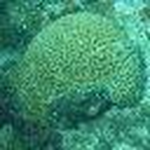

In [ ]:
display(show_image(X_train_cover[2]))

In [ ]:
!pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


### Data preparation

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, secret, cover, batch_size, shuffle=True):
        self.secret = secret
        self.cover = cover
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.datalen = len(secret)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index: int):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        secret_batch = np.array(self.secret)[batch_indexes]
        cover_batch = np.array(self.cover)[batch_indexes]

        return [secret_batch, cover_batch], [secret_batch, cover_batch]

    def __len__(self):
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
for i in range(len(X_train_secret)):
    X_train_secret[i] = tf.keras.utils.img_to_array(X_train_secret[i].convert('RGB'))
    X_train_cover[i] = tf.keras.utils.img_to_array(X_train_cover[i].convert('RGB'))

for i in range(len(X_test_secret)):
    X_test_secret[i] = tf.keras.utils.img_to_array(X_test_secret[i].convert('RGB'))
    X_test_cover[i] = tf.keras.utils.img_to_array(X_test_cover[i].convert('RGB'))

for i in range(len(X_val_secret)):
    X_val_secret[i] = tf.keras.utils.img_to_array(X_val_secret[i].convert('RGB'))
    X_val_cover[i] = tf.keras.utils.img_to_array(X_val_cover[i].convert('RGB'))

In [ ]:
train_gen = DataGenerator(X_train_secret, X_train_cover, BATCH_SIZE)
test_gen = DataGenerator(X_test_secret, X_test_cover, BATCH_SIZE, shuffle=False)
val_gen = DataGenerator(X_val_secret, X_val_cover, BATCH_SIZE, shuffle=False)

### Training model

In [ ]:
history = model.fit(
    train_gen,
    epochs=2,
    validation_data=val_gen,
    verbose=1,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/2
210/210 [==============================] - 130s 619ms/step - loss: 1258.6440 - reveal_layer_loss: 917.1584 - hide_layer_loss: 341.4863 - val_loss: 2085.8354 - val_reveal_layer_loss: 1716.0587 - val_hide_layer_loss: 369.7767
Epoch 2/2
210/210 [==============================] - 128s 610ms/step - loss: 1240.8361 - reveal_layer_loss: 904.1882 - hide_layer_loss: 336.6477 - val_loss: 1907.9490 - val_reveal_layer_loss: 1554.5510 - val_hide_layer_loss: 353.3982


### Testing model

In [ ]:
pred = model.predict(test_gen)

23/23 [==============================] - 3s 133ms/step


<ipython-input-15-083343a5c667>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)


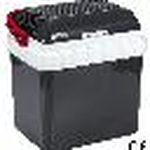

In [ ]:
n=5
display(show_image(X_test_secret[n])) # Secret

<ipython-input-15-083343a5c667>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)


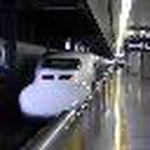

In [ ]:
display(show_image(X_test_cover[n]))  # Cover

<ipython-input-15-083343a5c667>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)


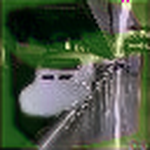

In [ ]:
display(show_image(pred[1][n]))  # Cover with secret

Container image


<ipython-input-15-083343a5c667>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)
<ipython-input-26-8c765ffc9350>:45: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)


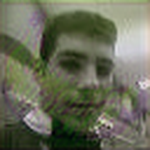

Decryted Container image


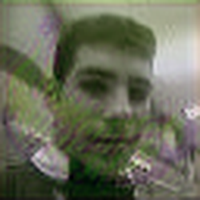

In [ ]:
from Crypto.Cipher import Blowfish
from Crypto.Protocol.KDF import PBKDF2
from Crypto import Random
from PIL import Image, ImageDraw
import numpy as np
import io
from IPython.display import display

def pad(data):
    block_size = Blowfish.block_size
    padding = block_size - len(data) % block_size
    return data + bytes([padding] * padding)

def encrypt_image(image_data, key):
    iv = Random.new().read(Blowfish.block_size)
    cipher = Blowfish.new(key, Blowfish.MODE_CBC, iv)

    padded_data = pad(image_data)
    encrypted_data = iv + cipher.encrypt(padded_data)

    return encrypted_data

def decrypt_image(encrypted_data, key):
    iv = encrypted_data[:Blowfish.block_size]
    cipher = Blowfish.new(key, Blowfish.MODE_CBC, iv)
    decrypted_data = cipher.decrypt(encrypted_data[Blowfish.block_size:])

    return decrypted_data[:-decrypted_data[-1]]  # Remove padding bytes

def encrypted_data_to_image(encrypted_data):
    # Create a blank image of a known format (e.g., PNG)
    encrypted_image = Image.new("RGB", (300, 300), (220, 255, 255))

    # Draw the encrypted data onto the image
    draw = ImageDraw.Draw(encrypted_image)
    draw.text((92, 142), "SECRET SHUSH", fill=(12, 50, 10))

    return encrypted_image

def show_image_data(arr, width=200, height=200):
    # Convert the array to a PIL Image object
    img = Image.fromarray(np.array(arr, dtype=np.uint8))

    # Resize the image to the specified width and height
    img = img.resize((width, height), Image.ANTIALIAS)

    # Convert the PIL Image to raw image data
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_data = img_byte_arr.getvalue()

    return img_data

# Example usage
key = PBKDF2(b"password", b"salt", dkLen=32)  # Generate a 256-bit key using PBKDF2

# Create or load the image array (for demonstration, we use a random image)
arr = np.random.randint(0, 256, (200, 200, 3), dtype=np.uint8)

# Get the raw image data
image_data = show_image_data(show_image(pred[1][0]))
print("Container image")
display(show_image(pred[1][0]))
# Encrypting the image data
encrypted_data = encrypt_image(image_data, key)
#print(encrypted_data)
# Convert encrypted data to an image
encrypted_image = encrypted_data_to_image(encrypted_data)

# Display the encrypted image
#display(encrypted_image)
print("Decryted Container image")
# Decrypt the encrypted data
decrypted_data = decrypt_image(encrypted_data, key)

# Open the decrypted data as an image
decrypted_image = Image.open(io.BytesIO(decrypted_data))

# Display the decrypted image
display(decrypted_image)


<ipython-input-15-083343a5c667>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((width, height), Image.ANTIALIAS)


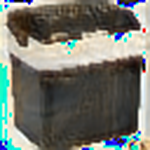

In [ ]:
display(show_image(pred[0][n]))  # Revealed